## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from fastai.vision import *

## Getting and converting the data

In [10]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [18]:
test = path/'09'
test.ls()

[PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00074_pose.txt'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00453_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00244_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00813_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00830_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00354_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00801_pose.txt'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00033_pose.txt'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00580_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00747_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00368_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00167_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/dat

In [12]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [13]:
# photo file name XXX_rgb.jpg; label(position of head) file name XXX_post.txt
fname = '09/frame_00667_rgb.jpg'
fname[:-7]

'09/frame_00667_'

In [14]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

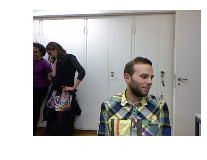

In [15]:
img = open_image(path/fname)
img.show()

In [19]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [20]:
# functions needed to parse the coordinates correctly, required by data
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

# converts the 3-elem dimension to 2-elem dimension
def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

# plot center of head on image; ImagePoints class require FlowField class as args which only serves as a wrapper
def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [21]:
get_ctr(fname)

tensor([263.9104, 428.5814])

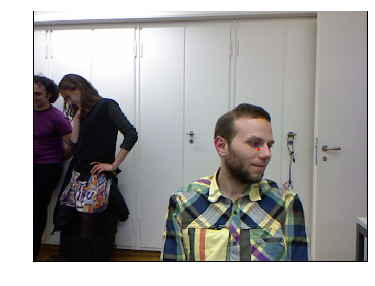

In [22]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [34]:
# PointsItemList class specifically for 'Image to ImagePoint' task (i.e. image regression task)
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13') # take all data of subject 13 to be the valid group
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

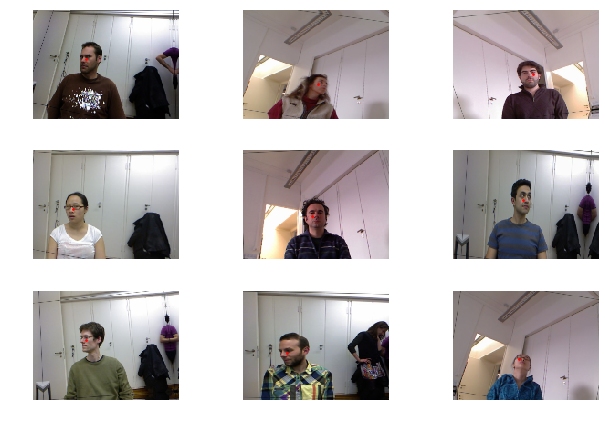

In [24]:
data.show_batch(3, figsize=(9,6))

## Train model

In [25]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


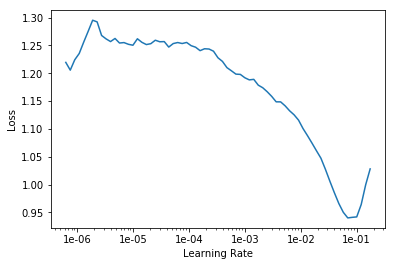

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 2e-2

In [28]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.044451,0.014258,00:55
1,0.016851,0.006153,00:55
2,0.007564,0.002876,00:55
3,0.004780,0.001836,00:55
4,0.003499,0.000494,00:56


In [29]:
learn.save('stage-1')

In [30]:
learn.load('stage-1');

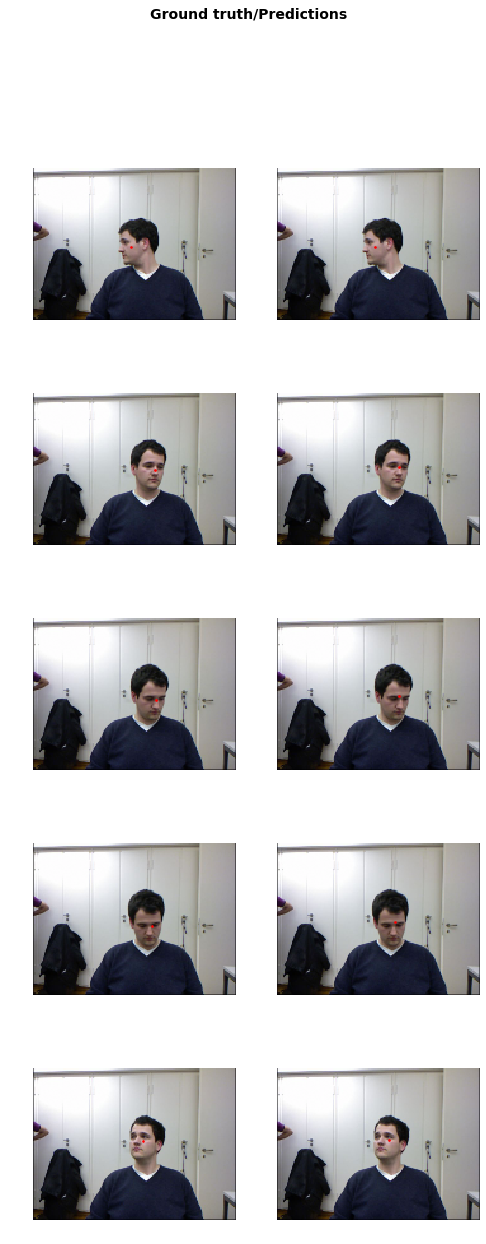

In [31]:
learn.show_results()

## Data augmentation

In [32]:
# tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

# data = (PointsItemList.from_folder(path)
#         .split_by_valid_func(lambda o: o.parent.name=='13')
#         .label_from_func(get_ctr)
#         .transform(get_transforms(), tfm_y=True, size=(120,160))
#         .databunch().normalize(imagenet_stats)
#        )

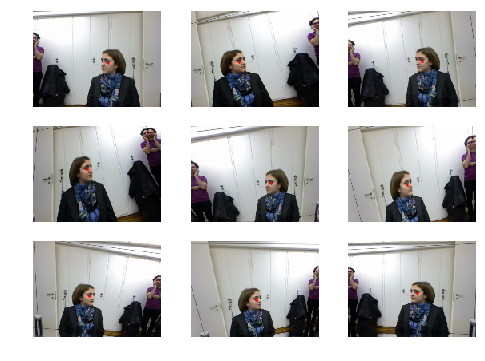

In [35]:
# def _plot(i,j,ax):
#     x,y = data.train_ds[0]
#     x.show(ax, y=y)

# plot_multi(_plot, 3, 3, figsize=(8,6))